In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

In [ ]:
!tar xf spark-3.5.1-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]='/content/spark-3.5.1-bin-hadoop3'

In [ ]:
!pip install -q findspark
import findspark

In [ ]:
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.5.1-bin-hadoop3'

In [ ]:
from pyspark.sql.functions import col

In [ ]:
import pyspark
sc = pyspark.SparkContext(appName="analysis_property_damage1")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Historical_Crime').getOrCreate()

df = spark.read.csv('/content/drive/MyDrive/hiscrimdata.csv', header=True, inferSchema=True)

In [ ]:
df = df.filter(
    (col("Type") == "Break and Enter Commercial") |
    (col("Type") == "Break and Enter Residential/Other") |
    (col("Type") == "Mischief")
)

df.show()

+--------------------+----+-----+---+----+------+---------------+-------------+-----------+------------+
|                TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|  HUNDRED_BLOCK|NEIGHBOURHOOD|          X|           Y|
+--------------------+----+-----+---+----+------+---------------+-------------+-----------+------------+
|Break and Enter C...|2012|   12| 14|   8|    52|           NULL|     Oakridge|   491285.0|   5453433.0|
|Break and Enter C...|2019|    3|  7|   2|     6|  10XX SITKA SQ|     Fairview|490612.9648|5457109.8223|
|Break and Enter C...|2019|    8| 27|   4|    12|10XX ALBERNI ST|     West End|491007.7798|5459174.3376|
|Break and Enter C...|2021|    4| 26|   4|    44|10XX ALBERNI ST|     West End|491007.7798|5459174.3376|
|Break and Enter C...|2014|    8|  8|   5|    13|10XX ALBERNI ST|     West End|491015.9434|5459166.1397|
|Break and Enter C...|2020|    7| 28|  19|    12|10XX ALBERNI ST|     West End|491015.9434|5459166.1397|
|Break and Enter C...|2005|   11| 14|   3|     9|10XX A

In [ ]:
from pyspark.sql.functions import col, sum

#Find Missing values
missing_data_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_data_counts.show()

+----+----+-----+---+----+------+-------------+-------------+---+---+
|TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|HUNDRED_BLOCK|NEIGHBOURHOOD|  X|  Y|
+----+----+-----+---+----+------+-------------+-------------+---+---+
|   0|   0|    0|  0|   0|     0|            3|            0|  0|  0|
+----+----+-----+---+----+------+-------------+-------------+---+---+



In [ ]:
#Process data
df = df.dropna() #Drop missing values
df = df.dropDuplicates() # Remove duplicate rows

df.show()

+--------------------+----+-----+---+----+------+-------------------+--------------------+-----------+------------+
|                TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|      HUNDRED_BLOCK|       NEIGHBOURHOOD|          X|           Y|
+--------------------+----+-----+---+----+------+-------------------+--------------------+-----------+------------+
|Break and Enter C...|2011|    7| 29|  22|     0|    10XX ALBERNI ST|            West End|491073.0275|5459108.8154|
|Break and Enter C...|2008|    4|  2|   4|     0|    10XX ALBERNI ST|            West End|491101.3372| 5459093.346|
|Break and Enter C...|2009|    2| 27|   0|     0|     10XX BEACH AVE|Central Business ...|  490269.91|5458141.1263|
|Break and Enter C...|2017|   11| 17|  14|    30|  10XX BROUGHTON ST|            West End|490262.7487|5459186.8583|
|Break and Enter C...|2013|   10| 20|   6|    48|    10XX BURNABY ST|            West End|490500.2381|5458425.9166|
|Break and Enter C...|2010|    4| 30|   5|     0|    10XX BURRARD ST|   

In [ ]:
df_summary = df.describe()
df_summary.show()

+-------+--------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+---------------+------------------+------------------+
|summary|                TYPE|              YEAR|             MONTH|              DAY|              HOUR|            MINUTE|       HUNDRED_BLOCK|  NEIGHBOURHOOD|                 X|                 Y|
+-------+--------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+---------------+------------------+------------------+
|  count|              205343|            205343|            205343|           205343|            205343|            205343|              205343|         205343|            205343|            205343|
|   mean|                NULL|2010.9748956623796|6.4549704640528285|15.45728366684036|12.251228432427695|18.428502554262867|                NULL|           NULL| 492284.0260995445|  5456428.55236097|


In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import concat_ws, col, to_date, date_format, sum, avg
from pyspark.sql.functions import dayofmonth, ceil


df = df.withColumn("Date", concat_ws("-", col("YEAR"), col("MONTH"), col("DAY")))
df = df.withColumn("Date", col("Date").cast("date"))

df = df.withColumn("day", dayofmonth("Date"))
df = df.withColumn("week_of_month", ceil(df.day / 7))

df.createOrReplaceTempView("CrimeData")

In [ ]:
df.show()

+--------------------+----+-----+---+----+------+-------------------+--------------------+-----------+------------+----------+-------------+
|                TYPE|YEAR|MONTH|day|HOUR|MINUTE|      HUNDRED_BLOCK|       NEIGHBOURHOOD|          X|           Y|      Date|week_of_month|
+--------------------+----+-----+---+----+------+-------------------+--------------------+-----------+------------+----------+-------------+
|Break and Enter C...|2011|    7| 29|  22|     0|    10XX ALBERNI ST|            West End|491073.0275|5459108.8154|2011-07-29|            5|
|Break and Enter C...|2008|    4|  2|   4|     0|    10XX ALBERNI ST|            West End|491101.3372| 5459093.346|2008-04-02|            1|
|Break and Enter C...|2009|    2| 27|   0|     0|     10XX BEACH AVE|Central Business ...|  490269.91|5458141.1263|2009-02-27|            4|
|Break and Enter C...|2017|   11| 17|  14|    30|  10XX BROUGHTON ST|            West End|490262.7487|5459186.8583|2017-11-17|            3|
|Break and En

Is there a relationship between mischief offenses and other types of property crimes?

In [ ]:
query6 = """
SELECT TYPE, COUNT(*) AS Count
FROM CrimeData
WHERE TYPE IN ('Break and Enter Commercial', 'Break and Enter Residential/Other', 'Mischief')
GROUP BY TYPE
"""

result6_df = spark.sql(query6)
result6_df.show()

result6_pd_df = result6_df.toPandas()

+--------------------+-----+
|                TYPE|Count|
+--------------------+-----+
|            Mischief|92912|
|Break and Enter C...|43066|
|Break and Enter R...|69365|
+--------------------+-----+



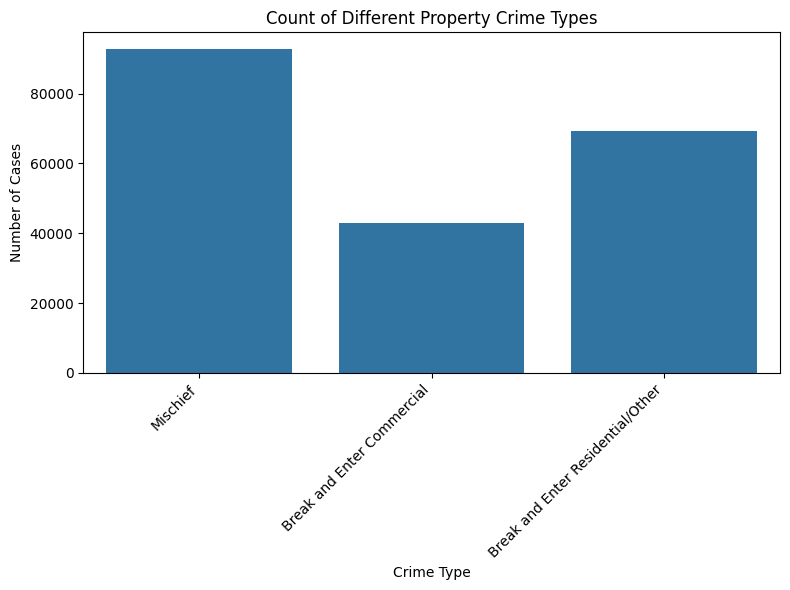

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(data=result6_pd_df, x='TYPE', y='Count')
plt.title('Count of Different Property Crime Types')
plt.xlabel('Crime Type')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

What are the peak times for property damage offenses during a 24-hour period?

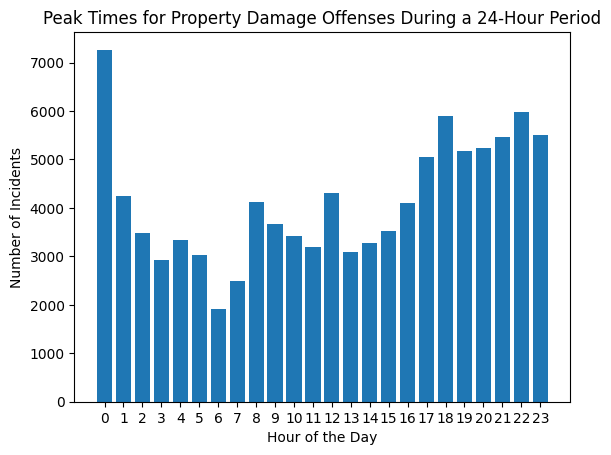

In [ ]:
q1 = spark.sql("""
SELECT TYPE, HOUR, COUNT(*) AS Count
FROM CrimeData
WHERE TYPE = 'Break and Enter Commercial'
   OR TYPE = 'Break and Enter Residential/Other'
   OR TYPE = 'Mischief'
GROUP BY TYPE, HOUR
ORDER BY Count DESC
""")

q1_results = q1.collect()
type = [row.TYPE for row in q1_results]  # Get a list of hour values
hours = [row.HOUR for row in q1_results]  # Get a list of hour values
counts = [row.Count for row in q1_results]

plt.bar(hours, counts)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.title('Peak Times for Property Damage Offenses During a 24-Hour Period')
plt.xticks(range(0, 24))  # Ensures all hours are displayed on the x-axis
plt.show()


What is the distribution of property damage across different weeks?

In [ ]:
q2 = spark.sql("""
SELECT TYPE, week_of_month AS Week, COUNT(*) AS Count
FROM CrimeData
WHERE TYPE = 'Break and Enter Commercial'
   OR TYPE = 'Break and Enter Residential/Other'
   OR TYPE = 'Mischief'
GROUP BY TYPE, week_of_month
ORDER BY Count DESC
""")


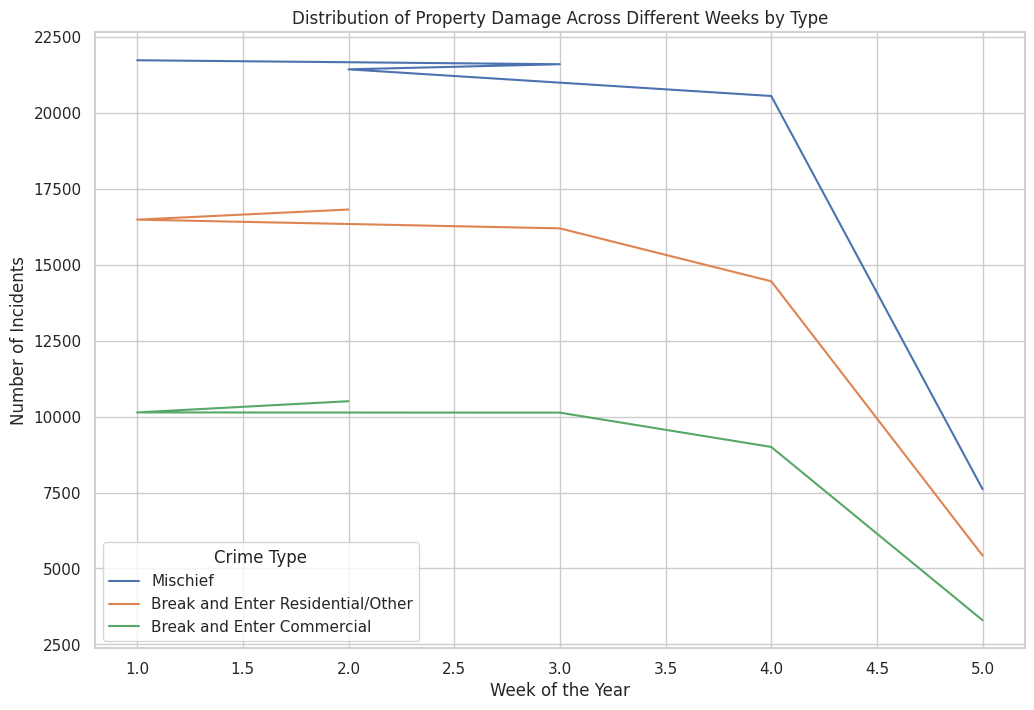

In [ ]:
import seaborn as sns

q2_df = q2.toPandas()

# Set the plot style
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(12, 8))
for crime_type in q2_df['TYPE'].unique():
    subset = q2_df[q2_df['TYPE'] == crime_type]
    plt.plot(subset['Week'], subset['Count'], label=crime_type)

plt.xlabel('Week of the Year')
plt.ylabel('Number of Incidents')
plt.title('Distribution of Property Damage Across Different Weeks by Type')
plt.legend(title='Crime Type')
plt.show()

Are there specific months with higher incidences of property damage offenses?

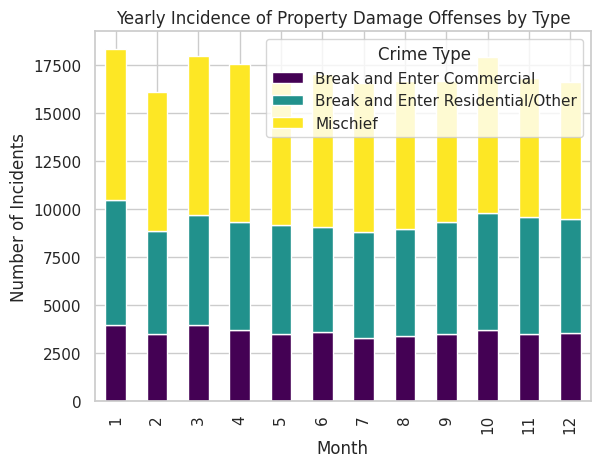

In [ ]:
q3 = spark.sql("""
SELECT TYPE, Month, COUNT(*) AS Count
FROM CrimeData
WHERE TYPE IN ('Break and Enter Commercial', 'Break and Enter Residential/Other', 'Mischief')
GROUP BY TYPE, Month
ORDER BY Month, TYPE
""")

# Convert the result to Pandas DataFrame for plotting
q3_df = q3.toPandas()
#Pivot table to get types as columns and months as index
q3_pivot_df = q3_df.pivot(index='Month', columns='TYPE', values='Count').fillna(0)

#Create stacked bar plot using percentage
q3_pivot_df.plot(kind='bar', stacked=True, colormap='viridis')


Are there identifiable trends in property damage offenses over multiple years?

+--------------------+----+-----+
|                TYPE|YEAR|Count|
+--------------------+----+-----+
|Break and Enter C...|2003| 3198|
|Break and Enter R...|2003| 6885|
|            Mischief|2003| 6390|
|Break and Enter C...|2004| 3283|
|Break and Enter R...|2004| 6536|
|            Mischief|2004| 5600|
|Break and Enter C...|2005| 2640|
|Break and Enter R...|2005| 5542|
|            Mischief|2005| 5064|
|Break and Enter C...|2006| 2845|
|Break and Enter R...|2006| 5672|
|            Mischief|2006| 5182|
|Break and Enter C...|2007| 2435|
|Break and Enter R...|2007| 4997|
|            Mischief|2007| 4815|
|Break and Enter C...|2008| 2225|
|Break and Enter R...|2008| 4432|
|            Mischief|2008| 5275|
|Break and Enter C...|2009| 1859|
|Break and Enter R...|2009| 3497|
+--------------------+----+-----+
only showing top 20 rows



<Figure size 1200x800 with 0 Axes>

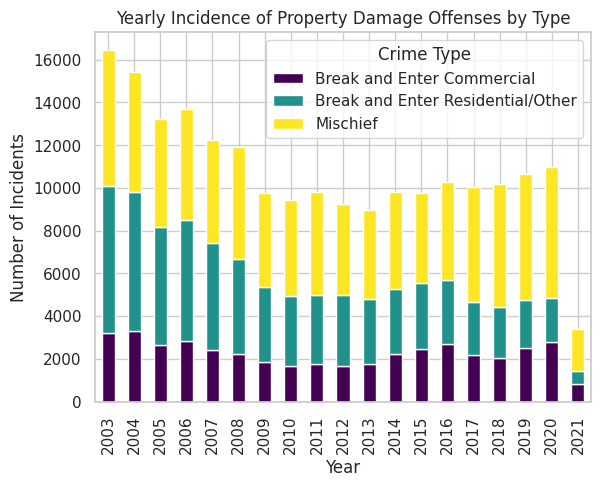

In [ ]:
query4 = """
SELECT TYPE, YEAR, COUNT(*) AS Count
FROM CrimeData
WHERE TYPE IN ('Break and Enter Commercial', 'Break and Enter Residential/Other', 'Mischief')
GROUP BY TYPE, YEAR
ORDER BY YEAR, TYPE
"""

result4_df = spark.sql(query4)
result4_df.show()

result4_pd_df = result4_df.toPandas()

# Pivot the DataFrame to create a pivot table
pivot_df = result4_pd_df.pivot(index='YEAR', columns='TYPE', values='Count').fillna(0)

# Create a stacked bar plot
plt.figure(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Yearly Incidence of Property Damage Offenses by Type')
plt.legend(title='Crime Type')
plt.show()

How do property damage offense patterns differ between residential and commercial areas?

<ipython-input-26-eb15a2de5601>:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=result_pd_df, x='Month', y='Count', hue='TYPE', ci=None)


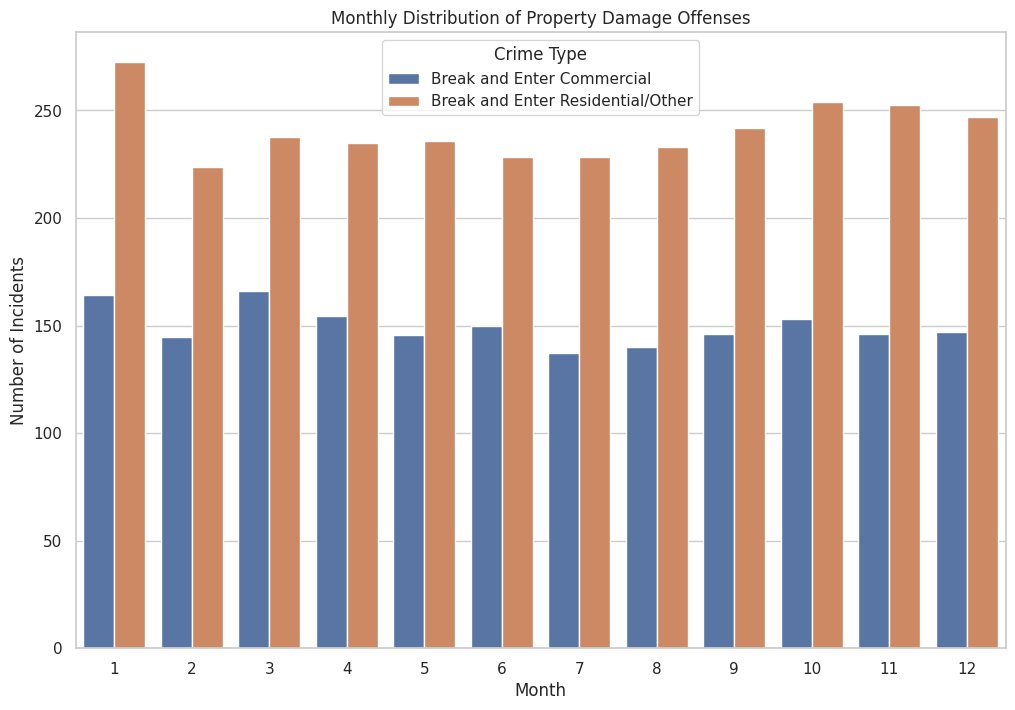

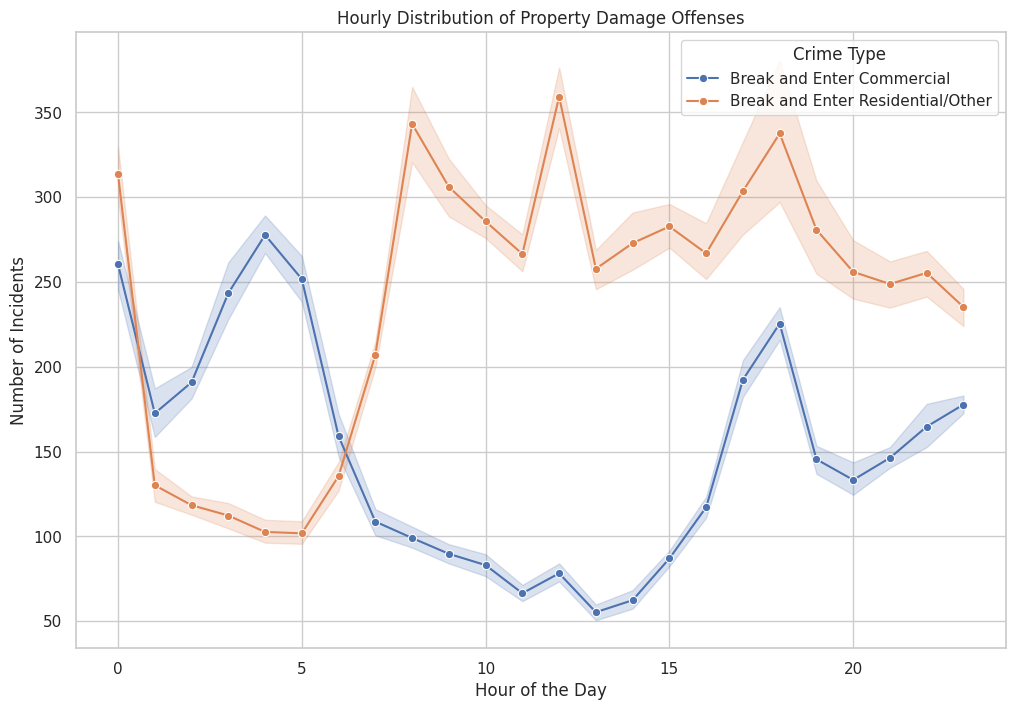

In [ ]:
query = """
SELECT
    TYPE,
    Month,
    Hour,
    COUNT(*) AS Count
FROM
    CrimeData
WHERE
    TYPE IN ('Break and Enter Commercial', 'Break and Enter Residential/Other')
GROUP BY
    TYPE,
    Month,
    Hour
ORDER BY
    Month,
    Hour,
    TYPE
"""

# Execute the SQL query
result_df = spark.sql(query)

# Convert the result to Pandas DataFrame for plotting
result_pd_df = result_df.toPandas()

# Set the plot style
sns.set(style="whitegrid")

# Plotting the data

# 1. Monthly Distribution
plt.figure(figsize=(12, 8))
sns.barplot(data=result_pd_df, x='Month', y='Count', hue='TYPE', ci=None)
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.title('Monthly Distribution of Property Damage Offenses')
plt.legend(title='Crime Type')
plt.show()

# 2. Hourly Distribution
plt.figure(figsize=(12, 8))
sns.lineplot(data=result_pd_df, x='Hour', y='Count', hue='TYPE', marker="o")
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.title('Hourly Distribution of Property Damage Offenses')
plt.legend(title='Crime Type')
plt.show()

Are there specific areas with a high incidence of property damage offenses during certain times of the year?

In [ ]:
query3 = """
WITH RankedCrimes AS (
    SELECT
        HUNDRED_BLOCK,
        TYPE,
        Month,
        COUNT(*) AS Count,
        ROW_NUMBER() OVER (PARTITION BY TYPE, Month ORDER BY COUNT(*) DESC) as Rank
    FROM
        CrimeData
    WHERE
        TYPE IN ('Break and Enter Commercial', 'Break and Enter Residential/Other', 'Mischief')
    GROUP BY
        TYPE,
        Month,
        HUNDRED_BLOCK
)
SELECT
    HUNDRED_BLOCK,
    TYPE,
    Month,
    Count
FROM
    RankedCrimes
WHERE
    Rank <= 5
ORDER BY
    TYPE,
    Month,
    Rank
"""

result3_df = spark.sql(query3)
result3_df.show()

result3_pd_df = result3_df.toPandas()

+------------------+--------------------+-----+-----+
|     HUNDRED_BLOCK|                TYPE|Month|Count|
+------------------+--------------------+-----+-----+
|      3XX WATER ST|Break and Enter C...|    1|   29|
|      1XX WATER ST|Break and Enter C...|    1|   19|
|    3XX RAILWAY ST|Break and Enter C...|    1|   16|
|     10XX HOMER ST|Break and Enter C...|    1|   15|
|25XX E HASTINGS ST|Break and Enter C...|    1|   14|
|      3XX WATER ST|Break and Enter C...|    2|   29|
|      1XX WATER ST|Break and Enter C...|    2|   15|
|    11XX ROBSON ST|Break and Enter C...|    2|   15|
|    5XX SEYMOUR ST|Break and Enter C...|    2|   14|
|7XX W BROADWAY AVE|Break and Enter C...|    2|   14|
|      3XX WATER ST|Break and Enter C...|    3|   20|
| 10XX GRANVILLE ST|Break and Enter C...|    3|   17|
|  7XX W GEORGIA ST|Break and Enter C...|    3|   16|
|    3XX RAILWAY ST|Break and Enter C...|    3|   16|
|      1XX WATER ST|Break and Enter C...|    3|   14|
|      1XX WATER ST|Break an

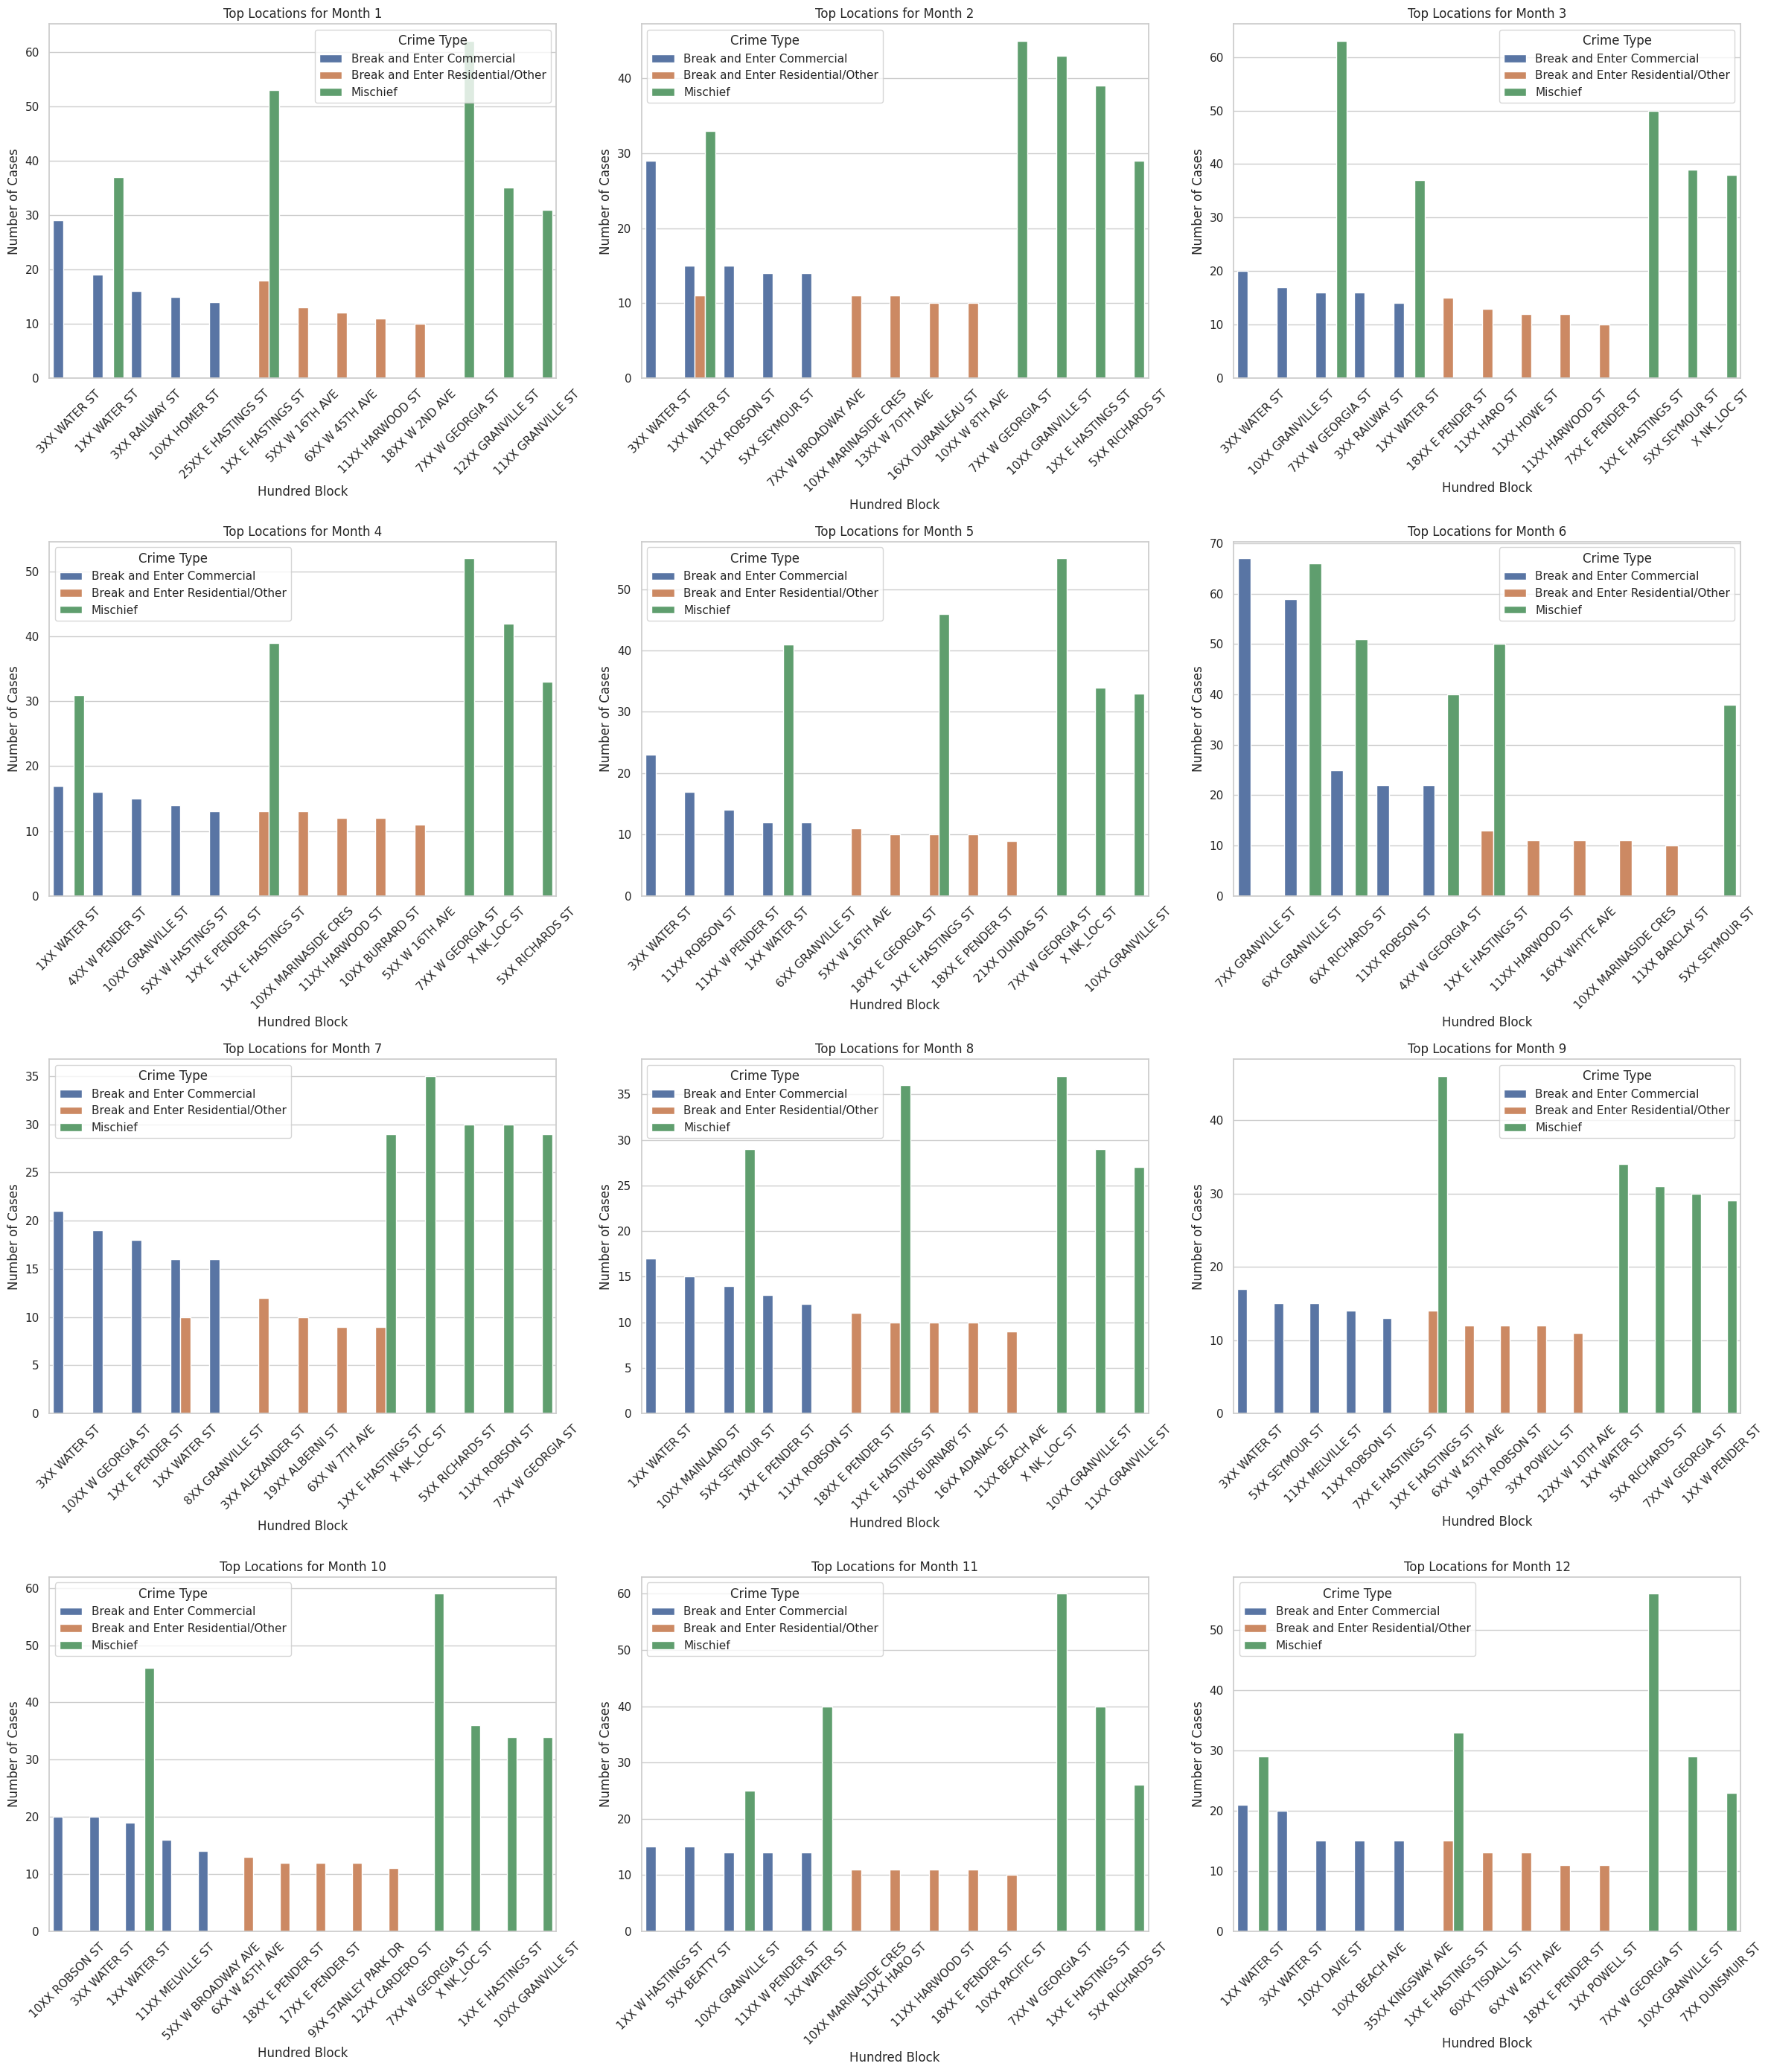

In [ ]:
months = sorted(result3_pd_df['Month'].unique())

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(24,28))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, month in enumerate(months):
    # Filter data for the current month
    month_data = result3_pd_df[result3_pd_df['Month'] == month]

    # Create a bar plot for the current month
    sns.barplot(
        data=month_data,
        x='HUNDRED_BLOCK',
        y='Count',
        hue='TYPE',
        ax=axes[i],
        errorbar=None
    )
    axes[i].set_title(f'Top Locations for Month {month}')
    axes[i].set_xlabel('Hundred Block')
    axes[i].set_ylabel('Number of Cases')
    axes[i].legend(title='Crime Type')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots (if there are less than 12 months)
for i in range(len(months), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

How is the frequency of offenses related to property damage in according to their specific location? - X, Y, Neighbourhood,

In [ ]:
query5 ="""
SELECT TYPE, NEIGHBOURHOOD, COUNT(TYPE) AS Count, X, Y
FROM CrimeData
WHERE TYPE IN ('Break and Enter Commercial', 'Break and Enter Residential/Other', 'Mischief')
GROUP BY NEIGHBOURHOOD, X, Y, TYPE
"""

result5_df = spark.sql(query5)
result5_df.show()

result5_pd_df = result5_df.toPandas()

+--------------------+--------------------+-----+-----------+------------+
|                TYPE|       NEIGHBOURHOOD|Count|          X|           Y|
+--------------------+--------------------+-----+-----------+------------+
|Break and Enter C...|      Mount Pleasant|    3|492580.0304|5456695.9185|
|Break and Enter C...|      Mount Pleasant|    6|492217.3592|5457492.8673|
|Break and Enter R...|           Killarney|    5|496866.6468|5453248.8366|
|Break and Enter R...|          Kerrisdale|    1|488549.4796| 5452308.873|
|            Mischief|Central Business ...|   12| 490918.957|5459505.4848|
|            Mischief| Renfrew-Collingwood|    4|497353.4108|5453516.2374|
|Break and Enter C...| Renfrew-Collingwood|    1|497708.2463|5453259.0102|
|Break and Enter C...|Kensington-Cedar ...|    5| 493427.777|5454257.3473|
|Break and Enter C...|Central Business ...|    4|491548.0589|5459195.7917|
|Break and Enter C...| Victoria-Fraserview|    1|495211.6049|5452489.3887|
|Break and Enter R...|   

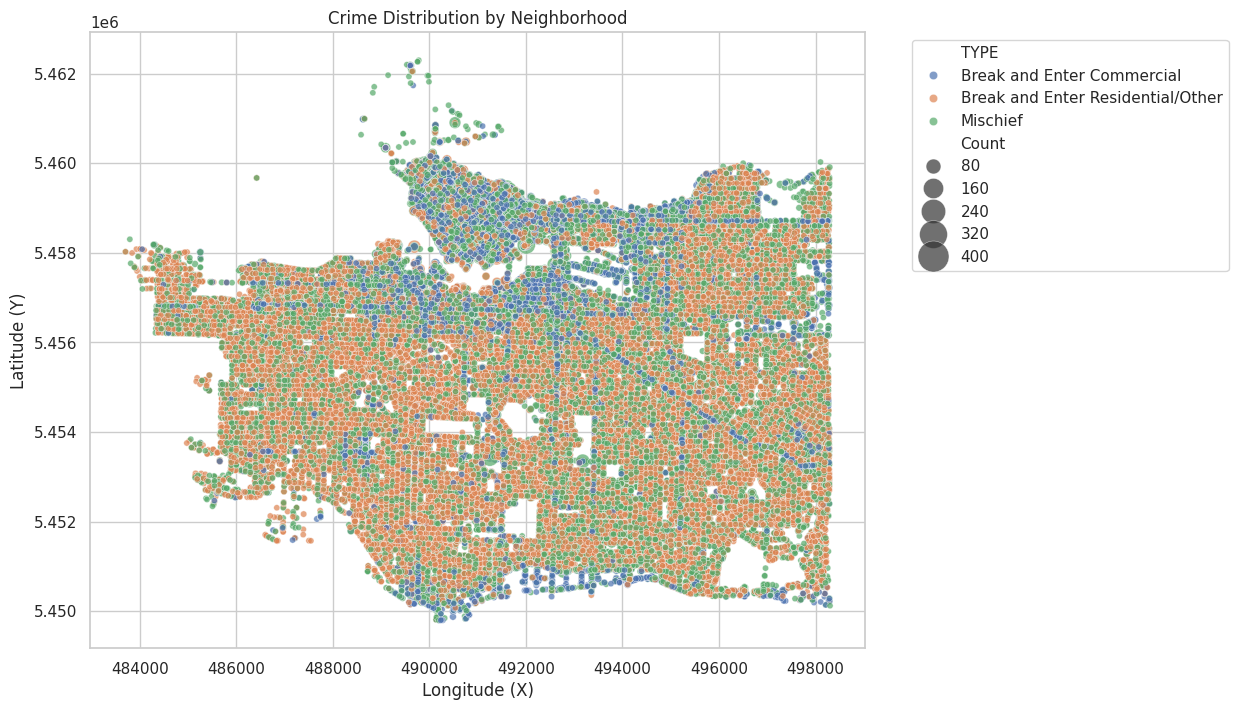

In [ ]:
# plt.figure(figsize=(10, 8))  # Adjust figure size as needed

# # Create the bubble chart
# plt.scatter(result5_pd_df['X'], result5_pd_df['Y'],
#             s=result5_pd_df['Count'] * 5,  # Adjust scaling factor for bubble size
#             alpha=0.7)  # Adjust transparency as needed

# plt.title('Crime Distribution by Neighborhood')
# plt.xlabel('Longitude (X)')
# plt.ylabel('Latitude (Y)')

# # Optionally, add labels for neighborhoods
# for i, row in result5_pd_df.iterrows():
#     plt.annotate(row['NEIGHBOURHOOD'], (row['X'], row['Y']))

# plt.grid(True)
# plt.show()

plt.figure(figsize=(10, 8))

# Create the bubble chart with hue for neighborhoods
sns.scatterplot(data=result5_pd_df,
                x='X',
                y='Y',
                size='Count',
                hue='TYPE',
                alpha=0.7,
                sizes=(20, 500))  # Adjust size range as needed

plt.title('Crime Distribution by Neighborhood')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')

plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.show()

What are the most common locations or areas for mischief offenses?

+--------------------+-----+
|       NEIGHBOURHOOD|Count|
+--------------------+-----+
|Central Business ...|23844|
|            West End| 7038|
|          Strathcona| 6993|
|  Grandview-Woodland| 6224|
|      Mount Pleasant| 5380|
| Renfrew-Collingwood| 4901|
|Kensington-Cedar ...| 4771|
|           Kitsilano| 4658|
|            Fairview| 4223|
|              Sunset| 3916|
+--------------------+-----+



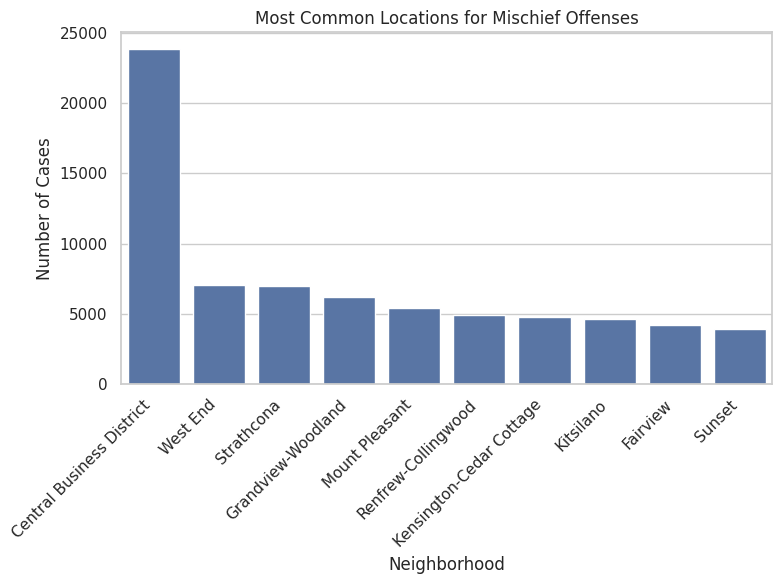

In [ ]:
query7 = """
SELECT NEIGHBOURHOOD, COUNT(*) AS Count
FROM CrimeData
WHERE TYPE = 'Mischief'
GROUP BY NEIGHBOURHOOD
ORDER BY Count DESC
LIMIT 10
"""

result7_df = spark.sql(query7)
result7_df.show()

result7_pd_df = result7_df.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(data=result7_pd_df, x='NEIGHBOURHOOD', y='Count')
plt.title('Most Common Locations for Mischief Offenses')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

How do mischief offenses compare to other types of property crimes in terms of frequency and distribution?

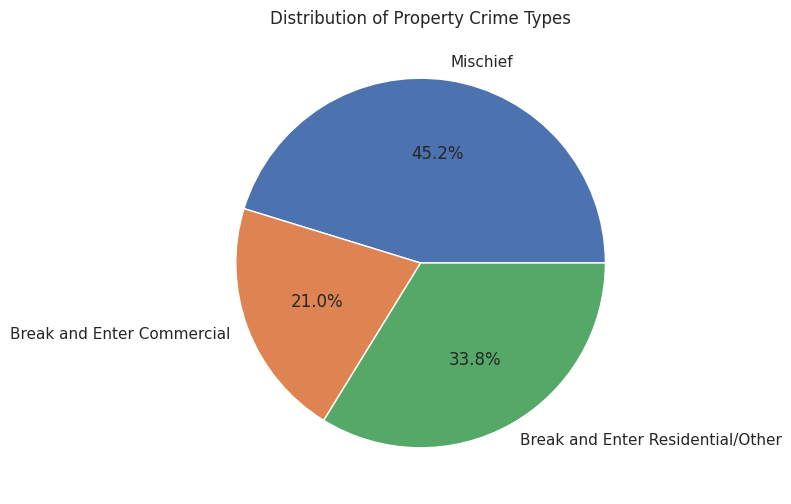

In [ ]:
!pip install folium

import folium

# --- Frequency Analysis ---

# Query to get counts of each property crime type
query6 = """
SELECT TYPE, COUNT(*) AS Count
FROM CrimeData
WHERE TYPE IN ('Break and Enter Commercial', 'Break and Enter Residential/Other', 'Mischief')
GROUP BY TYPE
"""
result6_df = spark.sql(query6)
result6_pd_df = result6_df.toPandas()

# Calculate overall percentages for each crime type
total_crimes = result6_pd_df['Count'].sum()
result6_pd_df['Percentage'] = (result6_pd_df['Count'] / total_crimes) * 100

# Visualize overall frequency with a pie chart
plt.figure(figsize=(6, 6))
plt.pie(result6_pd_df['Percentage'], labels=result6_pd_df['TYPE'], autopct='%1.1f%%')
plt.title('Distribution of Property Crime Types')
plt.show()

+--------------------+-----+-----+
|                TYPE|MONTH|Count|
+--------------------+-----+-----+
|Break and Enter C...|    1|  236|
|Break and Enter C...|    2|  182|
|Break and Enter C...|    3|  172|
|Break and Enter C...|    4|  178|
|Break and Enter C...|    5|   57|
|Break and Enter R...|    1|  141|
|Break and Enter R...|    2|  136|
|Break and Enter R...|    3|  116|
|Break and Enter R...|    4|  140|
|Break and Enter R...|    5|   75|
|            Mischief|    1|  495|
|            Mischief|    2|  423|
|            Mischief|    3|  439|
|            Mischief|    4|  433|
|            Mischief|    5|  194|
+--------------------+-----+-----+



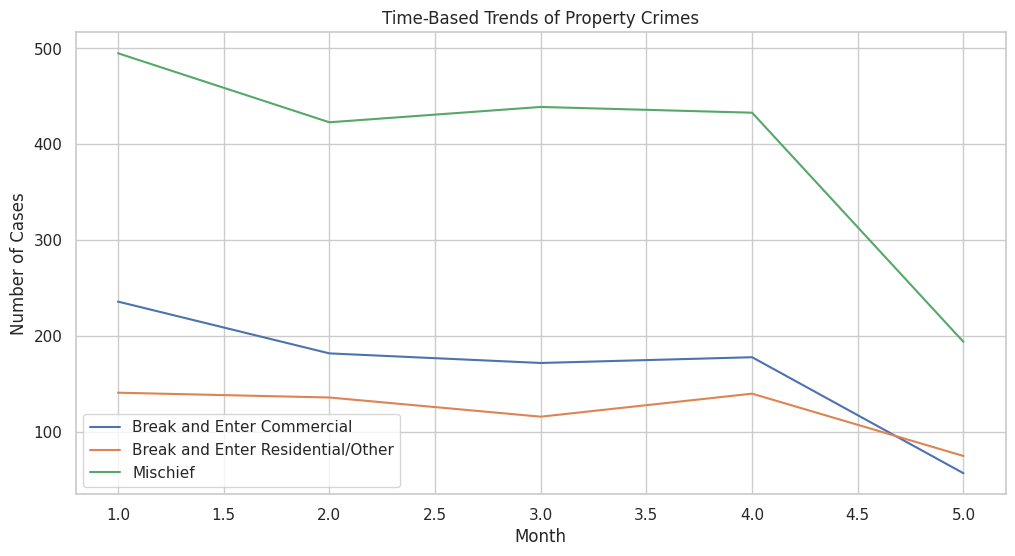

In [ ]:
query_time_trend = """
SELECT TYPE, MONTH, COUNT(*) AS Count
FROM CrimeData
WHERE YEAR = 2021
GROUP BY TYPE, MONTH
ORDER BY TYPE, MONTH
"""
result_time_trend_df = spark.sql(query_time_trend)
result_time_trend_df.show()

result_time_trend_pd_df = result_time_trend_df.toPandas()

# Pivot the data for plotting, setting both 'MONTH' and 'TYPE' as index
result_time_trend_pivot = result_time_trend_pd_df.pivot(index='MONTH', columns='TYPE', values='Count').fillna(0)

# Plot time series for each crime type
plt.figure(figsize=(12, 6))
for crime_type in result_time_trend_pivot.columns:
    plt.plot(result_time_trend_pivot.index, result_time_trend_pivot[crime_type], label=crime_type) # Access the single-level index directly
plt.xlabel('Month')
plt.ylabel('Number of Cases')
plt.title('Time-Based Trends of Property Crimes')
plt.legend()
plt.show()

In [ ]:
query_location = """
SELECT TYPE, X, Y
FROM CrimeData
WHERE TYPE IN ('Break and Enter Commercial', 'Break and Enter Residential/Other', 'Mischief')
"""
result_location_df = spark.sql(query_location)
result_location_pd_df = result_location_df.toPandas()

# Create a base map (adjust location as needed)
map_center = [result_location_pd_df['Y'].mean(), result_location_pd_df['X'].mean()]
crime_map = folium.Map(location=map_center, zoom_start=12)

# Add markers for each crime type with different colors
for index, row in result_location_pd_df.iterrows():
    if row['TYPE'] == 'Break and Enter Commercial':
        color = 'red'
    elif row['TYPE'] == 'Break and Enter Residential/Other':
        color = 'blue'
    else:  # Mischief
        color = 'green'
    folium.Marker([row['Y'], row['X']], popup=row['TYPE'], icon=folium.Icon(color=color)).add_to(crime_map)

# Display the map
display(crime_map)

How can predictive modeling help in identifying emerging hotspots for property damage offenses?

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when

# Check if columns already exist and drop if necessary
if 'TYPE_indexed' in df_assembled.columns: # Check in df_assembled, not df
    df_assembled = df_assembled.drop('TYPE_indexed')
if 'HUNDRED_BLOCK_indexed' in df_assembled.columns: # Check in df_assembled, not df
    df_assembled = df_assembled.drop('HUNDRED_BLOCK_indexed')
if 'TYPE_encoded' in df_assembled.columns: # Check in df_assembled, not df
    df_assembled = df_assembled.drop('TYPE_encoded')
if 'HUNDRED_BLOCK_encoded' in df_assembled.columns: # Check in df_assembled, not df
    df_assembled = df_assembled.drop('HUNDRED_BLOCK_encoded')


# Handle null values in StringIndexer
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="skip") for c in ["TYPE", "HUNDRED_BLOCK"]] # Set handleInvalid to 'skip'
encoders = [OneHotEncoder(inputCol="{0}_indexed".format(c), outputCol="{0}_encoded".format(c)) for c in ["TYPE", "HUNDRED_BLOCK"]]

# Update feature columns to use encoded columns
feature_columns = ["YEAR", "MONTH", "day", "HOUR", "TYPE_encoded", "HUNDRED_BLOCK_encoded"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Fit and transform the data using indexers and encoders
# Use df_assembled instead of df as it contains the 'TYPE' column
df_indexed = indexers[0].fit(df_assembled).transform(df_assembled)
df_encoded = encoders[0].fit(df_indexed).transform(df_indexed)
df_indexed = indexers[1].fit(df_encoded).transform(df_encoded)
df_encoded = encoders[1].fit(df_indexed).transform(df_indexed)

# Check if columns already exist and drop if necessary
if 'features' in df_encoded.columns:
    df_encoded = df_encoded.drop('features')
if 'TYPE_indexed' in df_encoded.columns:
    df_encoded = df_encoded.drop('TYPE_indexed')
if 'HUNDRED_BLOCK_indexed' in df_encoded.columns:
    df_encoded = df_encoded.drop('HUNDRED_BLOCK_indexed')

# Transform the data using the assembler (now with numeric features)
df_assembled = assembler.transform(df_encoded)

df_with_label = df_assembled.withColumn("label", when(df_assembled["TYPE"] == "Theft of Bicycle", 1).otherwise(0))

df = df_with_label.select("features", "label")

# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

# Create a logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Make predictions on the test set
predictions = lr_model.transform(test_data)

# Initialize evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluate the model
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc}")

# Make predictions on the test set
predictions = lr_model.transform(test_data)

# Initialize evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluate the model
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc}")

# Convert predictions to Pandas DataFrame for visualization
predictions_pd = predictions.select("features", "label", "prediction", "probability").toPandas()

# Extract coordinates and prediction probability
predictions_pd['X'] = predictions_pd['features'].apply(lambda x: float(x[4]))
predictions_pd['Y'] = predictions_pd['features'].apply(lambda x: float(x[5]))
predictions_pd['probability'] = predictions_pd['probability'].apply(lambda x: float(x[1]))

# Plot hotspots based on prediction probabilities
plt.figure(figsize=(10, 8))
sns.scatterplot(data=predictions_pd, x='X', y='Y', hue='probability', palette='coolwarm', size='probability', sizes=(20, 200))
plt.title('Predicted Hotspots for Property Damage Offenses')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Probability')
plt.show()